In [1]:
#! pip install -U gensim

In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as Dataset
import torch.autograd as autograd
from torch.utils.data import Dataset, DataLoader
import torchvision
import matplotlib.pyplot as plt
import nltk
from gensim.models import Word2Vec
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.model_selection import train_test_split
import time
import os
import pickle
import zipfile
from sklearn.utils import shuffle
#from torchsample.callbacks import EarlyStopping

In [21]:

#with zipfile.ZipFile("/Users/adityarane/Sequence network/515k-hotel-reviews-data-in-europe.zip","r") as zip_ref:
#    zip_ref.extractall("/Users/adityarane/Sequence network/Hotel_Reviews.csv")

In [22]:
#nltk.download('stopwords')

In [3]:
os.getcwd()

'/home/adityarane/Sequence_network'

In [3]:
#data = pd.read_csv('/home/adityarane/Sequence_network/Hotel_Reviews.csv',low_memory = False)
data = pd.read_csv('/home/adityarane/Sequence_network/Hotel_Reviews_small.csv')
data = data[['Review','Liked']]
data.rename(columns={"Review": "review"}, inplace=True)
#data = data[['Negative_Review','Positive_Review']]
data = shuffle(data)
print(data.head())

                                                   review  Liked
123425   I loved the location Within walking distance ...      1
342742                           No fuss value for money       1
480524                                     Small Bathroom      0
468533   Could not fault really Such friendly and welc...      1
437053   We love everything about this hotel Located i...      1


In [4]:
data.shape

(867640, 2)

In [26]:
#Negative_Review_data = data.Negative_Review.copy()
#Positive_Review_data = data.Positive_Review.copy()

In [27]:
#Negative_Review_data = Negative_Review_data[Negative_Review_data!= 'No Negative']
#Negative_Review_data = pd.DataFrame(Negative_Review_data)
#Negative_Review_data['Liked'] = 0
#Negative_Review_data.rename(columns={"Negative_Review": "Review"}, inplace=True)
#Negative_Review_data.shape

In [28]:
#Positive_Review_data = Positive_Review_data[Positive_Review_data!= 'No Positive']
#Positive_Review_data = pd.DataFrame(Positive_Review_data)
#Positive_Review_data['Liked'] = 1
#Positive_Review_data.rename(columns={"Positive_Review": "Review"}, inplace=True)
#Positive_Review_data.shape

In [29]:
#data = Positive_Review_data.append(Negative_Review_data)
#data.shape

In [30]:
#data.to_csv('/home/adityarane/Sequence_network/Hotel_Reviews_small.csv')

In [5]:
#remove html Tags
data['review'] = data['review'].str.lower()
data['review'] = data['review'].str.replace('<br','')
data['review'] = data['review'].str.replace('/>','')
data['review'] = data['review'].str.replace('[^\w\s]','')

#remove html Tags
special_chars = """!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"""
data['review'] = data['review'].apply(lambda x: " ".join(x for x in x.split() if x not in special_chars))

#remove numbers
numbers = '0123456789'
data['review'] = data['review'].apply(lambda x: " ".join(x for x in x.split() if x not in numbers))


#Remove stopwords
stop = stopwords.words('english')
data['review'] = data['review'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

data.head()

,review,Liked
123425,loved location within walking distance rail sy...,1
342742,fuss value money,1
480524,small bathroom,0
468533,could fault really friendly welcoming staff di...,1
437053,love everything hotel located heart city museu...,1


In [32]:
#data['Liked'] = np.where(data.sentiment == 'positive' , 1 , 0)
#data.head()

In [33]:
#data.groupby('Liked')['sentiment'].count()

In [6]:
data['review_length'] = data['review'].apply(lambda x: len(str(x).split(" ")))
data.head()

,review,Liked,review_length
123425,loved location within walking distance rail sy...,1,14
342742,fuss value money,1,3
480524,small bathroom,0,2
468533,could fault really friendly welcoming staff di...,1,30
437053,love everything hotel located heart city museu...,1,34


In [7]:
print('min sentence Length : {}'.format(data.review_length.min()))
print('max sentence Length : {}'.format(data.review_length.max()))
print('mean sentence Length : {}'.format(data.review_length.mean()))
print('median sentence Length : {}'.format(data.review_length.median()))

min sentence Length : 1
max sentence Length : 211
mean sentence Length : 10.912743764695035
median sentence Length : 7.0


In [8]:
sentence_corpus = []
for i in data.review:
    sentence_corpus.append(i.split())
len(sentence_corpus)

867640

In [9]:
#sentence_corpus

In [ ]:
vocab = []
for i in data.review:
    for j in i.split():
        if j not in vocab:
            vocab.append(j)
            
#vocab.append('<>')
vocab_size = len(vocab)
print('vocab_size : {}'.format(vocab_size))

In [39]:
with open('vocab', 'wb') as fp:
    pickle.dump(vocab, fp)
len(vocab)

81115

In [ ]:
vocab = pickle.load(open('vocab', 'rb'))

In [ ]:
word_to_idx = {}
idx_to_word = {}
for i in enumerate(vocab):
    #print(i)
    word_to_idx[i[1]] = i[0]
    idx_to_word[i[0]] = i[1]
print(len(word_to_idx))
print(len(idx_to_word))

In [42]:
#max_sentence_length = int(data.review_length.max())
#max_sentence_length = int(data.review_length.median())
max_sentence_length = 200
seq_len = max_sentence_length
print('max_sentence_length : {}'.format(max_sentence_length))
for i in range(0,len(sentence_corpus)):
    sentence = sentence_corpus[i]
    if len(sentence) < max_sentence_length :
        padding_length = max_sentence_length - len(sentence)
        #print(padding_length)
        for j in range(len(sentence) , max_sentence_length) :
            sentence.append('<>')

max_sentence_length : 200


In [ ]:
embedding_dim = 128
word2vec = Word2Vec(sentence_corpus, window=5 , min_count=1, size=embedding_dim)

In [ ]:
vocabulary = word2vec.wv.vocab
#print(vocabulary)

In [ ]:
with open('vocabulary.wordvectors', 'wb') as fp:
    pickle.dump(vocabulary, fp)

In [ ]:
vocabulary = pickle.load(open('vocabulary.wordvectors', 'rb'))

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print('cuda available, training on GPU')
else :
    device = torch.device("cpu")
    print('cuda NOT available, training on CPU')
#device = torch.device("cpu")   

In [ ]:
#creating training data

def vectorize_sentence(sentence):
    sentence = sentence.split()
    input_data = np.zeros((seq_len,embedding_dim))
    #print(corpus)
    k = 0
    for i in sentence:
        if k < seq_len : 
            if i == '<>':
                word_vector = np.zeros(embedding_dim)
            else:
                word_vector = word2vec.wv[i] 
            input_data[k] = word_vector
        else:
            continue
        k+=1
        #print(i)
    return input_data

#input_data = vectorize_sentence('oz like')

In [ ]:
#split data into trian test sets
train_size = 0.80
val_size = 0.10
test_size = (1 - train_size - val_size)
x_train , x_test, y_train , y_test = train_test_split(data.review, data.Liked, test_size=(test_size + val_size), random_state= 7)

x_val = x_test.head(int(val_size * (data.shape[0])))
y_val = y_test.head(int(val_size * (data.shape[0])))

x_test = x_test.tail(int(test_size * (data.shape[0])))
y_test = y_test.tail(int(test_size * (data.shape[0])))

print('x_train shape : {}'.format(x_train.shape))
print('y_train shape : {}\n'.format(y_train.shape))
print('x_test shape : {}'.format(x_test.shape))
print('y_test shape : {}\n'.format(y_test.shape))
print('x_val shape : {}'.format(x_val.shape))
print('y_val shape : {}'.format(y_val.shape))

In [ ]:
batch_size = 100
print('Using batch_size : {}'.format(batch_size))

In [ ]:
x_train_data = [] 
y_train_data = []
for idx in x_train.index:
    sentence = (x_train[idx])
    feature = vectorize_sentence(sentence)
    label = y_train[idx]
    x_train_data.append(feature)
    y_train_data.append(label)
    #print(feature)
    #print(label)
    
#Convert input data to tensors
x_train_data_tensor = torch.tensor(x_train_data)
y_train_data_tensor = torch.tensor(y_train_data)
print(x_train_data_tensor.shape)

#Convert tensors to type Dataset
train_dataset = torch.utils.data.TensorDataset(x_train_data_tensor ,y_train_data_tensor)
print(type(train_dataset))

#Convert datsets to Dataloader for loading batches
train_dataset = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
type(train_dataset)

In [ ]:
x_test_data = [] 
y_test_data = []
for idx in x_test.index:
    sentence = (x_test[idx])
    feature = vectorize_sentence(sentence)
    label = y_test[idx]
    x_test_data.append(feature)
    y_test_data.append(label)
    #print(feature)
    #print(label)
    
#Convert input data to tensors
x_test_data_tensor = torch.tensor(x_test_data)
y_test_data_tensor = torch.tensor(y_test_data)
print(x_test_data_tensor.shape)

#Convert tensors to type Dataset
test_dataset = torch.utils.data.TensorDataset(x_test_data_tensor ,y_test_data_tensor)
print(type(test_dataset))

#Convert datsets to Dataloader for loading batches
test_dataset = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
type(test_dataset)

In [ ]:
x_val_data = [] 
y_val_data = []
for idx in x_val.index:
    sentence = (x_val[idx])
    feature = vectorize_sentence(sentence)
    label = y_val[idx]
    x_val_data.append(feature)
    y_val_data.append(label)
    #print(feature)
    #print(label)
    
#Convert input data to tensors
x_val_data_tensor = torch.tensor(x_val_data)
y_val_data_tensor = torch.tensor(y_val_data)
print(x_val_data_tensor.shape)

#Convert tensors to type Dataset
val_dataset = torch.utils.data.TensorDataset(x_val_data_tensor ,y_val_data_tensor)
print(type(val_dataset))

#Convert datsets to Dataloader for loading batches
val_dataset = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
type(val_dataset)

In [ ]:
torch.save(val_dataset, 'val_dataset.dataloader')
torch.save(test_dataset, 'test_dataset.dataloader')
torch.save(train_dataset, 'train_dataset.dataloader')

In [6]:
#RUN this part if loaders are already saved
train_dataset = torch.load('train_dataset.dataloader')
print('train_dataset data loaded')

val_dataset = torch.load('val_dataset.dataloader')
print('val_dataset data loaded')

test_dataset = torch.load('test_dataset.dataloader')
print('test_dataset data loaded')


if torch.cuda.is_available():
    device = torch.device("cuda")
    print('cuda available, training on GPU')
else :
    device = torch.device("cpu")
    print('cuda NOT available, training on CPU')
##device = torch.device("cpu")   

embedding_dim = 64
batch_size = 500



train_dataset data loaded
val_dataset data loaded
test_dataset data loaded
cuda available, training on GPU


In [7]:
output_size = 2
input_size = embedding_dim
hidden_size = embedding_dim
num_layers = 1
batch_size = batch_size
drop_out_probability = 0.33


class SentimentRNN(nn.Module):
    def __init__(self , input_size , hidden_size , num_layers , output_size):
        super(SentimentRNN ,self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        
        #Input sequence of embedded word vectors
        self.lstm1 = nn.LSTM(input_size = input_size
                             , hidden_size = hidden_size 
                             , num_layers = num_layers
                             , batch_first = True 
                             ,dropout=drop_out_probability)
        
        # Inputs to hidden layer linear transformation
        self.fc1 = nn.Linear(in_features = input_size , out_features = hidden_size)
        #self.fc2 = nn.Linear(in_features = hidden_size , out_features = int(hidden_size/2))
        #self.fc3 = nn.Linear(in_features = int(hidden_size/2) , out_features = int(hidden_size/2))
        
        #Droput layer before output
        self.dropout = nn.Dropout(p = drop_out_probability)
        
        # Output layer, 10 units - one for each digit
        #self.out = nn.Linear(in_features = int(hidden_size/2) , out_features = output_size)
        self.out = nn.Linear(in_features = hidden_size , out_features = output_size)
        
    def _init_hidden(self,batch_size):
        hidden = torch.zeros((self.num_layers, batch_size , self.hidden_size),dtype = torch.float64)
        c_0 = torch.zeros((self.num_layers, batch_size , self.hidden_size),dtype = torch.float64)
        return hidden.to(device) , c_0.to(device)
        #return hidden.cpu() , c_0.cpu()
        
    def forward(self,x):
        
        #create initial hidden layer of zeros and intial state of zeros
        hidden , c_0 = self._init_hidden(batch_size)
        #print('hidden :{}'.format(hidden.shape))
        
        # Pass the input tensor through LSTM
        lstm_out ,hidden = self.lstm1(x,(hidden,c_0))
        #print('lstm_out :{}'.format(lstm_out.shape))
        
        #Transpose tensor before feeding into Linear layer
        lstm_out = lstm_out.transpose(dim0 = 0, dim1 = 1)
        #Pass output og LSTM through Fully connected layer
        x = self.fc1(lstm_out[-1]) #pass only last output to fully connected layer
        #print('x :{}'.format(x.shape))
        x = F.relu(x)
        
        #2nd hidden layer
        #x = self.fc2(x)
        #x = F.relu(x)
        
        #3rd hidden layer
        #x = self.fc3(x)
        #x = F.relu(x)
        
        #Dropout layer
        x = self.dropout(x)
        x = F.relu(x)
        
        #Output layer
        x = self.out(x)
        #x = F.sigmoid(x)
        
        return x
    
sentimentrnn = SentimentRNN(input_size = input_size 
                            , hidden_size = hidden_size 
                            , num_layers = num_layers
                            , output_size = output_size )
sentimentrnn.double()
sentimentrnn.to(device)
#sentimentrnn.cuda()

/home/adityarane/.local/lib/python3.5/site-packages/torch/nn/modules/rnn.py:54: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.33 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


SentimentRNN(
  (lstm1): LSTM(64, 64, batch_first=True, dropout=0.33)
  (fc1): Linear(in_features=64, out_features=64, bias=True)
  (dropout): Dropout(p=0.33)
  (out): Linear(in_features=64, out_features=2, bias=True)
)

In [8]:
torch.cuda.empty_cache()

In [9]:
epochs = 2
loss_fn = F.cross_entropy
#loss_fn =  F.nll_loss
#loss_fn = F.mse_loss
learning_rate = 0.001

optimizer = torch.optim.Adam(sentimentrnn.parameters(), lr = learning_rate)
#optimizer = torch.optim.RMSprop(sentimentrnn.parameters(), lr = learning_rate)
print_every = 50
sentimentrnn.to(device)


# to track the average training loss per epoch as the model trains
avg_train_losses = []
# to track the average validation loss per epoch as the model trains
avg_valid_losses = [] 
patience_ctr = 0
patience = 5
    
for epoch in range(0,epochs):
    
    # to track the training loss as the model trains
    train_losses = []
    # to track the validation loss as the model trains
    valid_losses = []

    batch = 0
    #loss = 0
    start_time = time.time()
    sentimentrnn.train()
    for i in train_dataset :
        x, y = next(iter(train_dataset))
        x = x.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
        y_pred = sentimentrnn(x)
        
        loss = loss_fn(y_pred , y)
        loss.backward()
        optimizer.step()
        
        train_losses.append(loss.item())
        
        if batch % print_every == 0:
            print('epoch : {} \t batch number : {} \t train loss : {}'.format(epoch, batch,loss.item()))
            
        batch +=1
    
    print('\nepoch : {} \t train loss : {} \t time required : {}'.format(epoch, loss.item(),(time.time() - start_time)))
    
    #Calculate Validation loss
    val_acc = 0
    sentimentrnn.eval()
    for j in val_dataset :
        x_v, y_v = next(iter(val_dataset))
        x_v = x_v.to(device)
        y_v = y_v.to(device)
        
        y_pred = sentimentrnn(x_v)
        loss = loss_fn(y_pred , y_v)
        
        valid_losses.append(loss.item())
        
    # print training/validation statistics 
    # calculate average loss over an epoch
    train_loss = np.average(train_losses)
    valid_loss = np.average(valid_losses)
    avg_train_losses.append(train_loss)
    avg_valid_losses.append(valid_loss)
    
    
    #Early stopping
    if valid_loss > train_loss:
        patience_ctr +=1
        print('patience_ctr : {}'.format(patience_ctr))
        if patience_ctr >= patience:
            print('early stoppping since valid_loss > train_loss')
            #break
    else :
        patience_ctr = 0
    
    epoch_len = len(str(epochs))
        
    #print('epoch : {} \t validation loss : {} \t time required : {} \n'.format(epoch, loss.item(),(time.time() - start_time)))

    print('epoch : {}\t train_loss :{}\t validation loss : {}\n'.format(epoch , train_loss , valid_loss))

epoch : 0 	 batch number : 0 	 train loss : 0.6964970449882213
epoch : 0 	 batch number : 50 	 train loss : 0.290643731065399
epoch : 0 	 batch number : 100 	 train loss : 0.21596144890250135
epoch : 0 	 batch number : 150 	 train loss : 0.20128884787578546
epoch : 0 	 batch number : 200 	 train loss : 0.19448205300120466
epoch : 0 	 batch number : 250 	 train loss : 0.18854510077496986
epoch : 0 	 batch number : 300 	 train loss : 0.1525709777916532
epoch : 0 	 batch number : 350 	 train loss : 0.19007151402875788
epoch : 0 	 batch number : 400 	 train loss : 0.1885195579223875
epoch : 0 	 batch number : 450 	 train loss : 0.19913910020459205
epoch : 0 	 batch number : 500 	 train loss : 0.1869398066020362


Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/util.py", line 254, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.5/multiprocessing/util.py", line 186, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.5/shutil.py", line 484, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/usr/lib/python3.5/shutil.py", line 482, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-4w6h434m'


epoch : 0 	 batch number : 550 	 train loss : 0.1973734224724397
epoch : 0 	 batch number : 600 	 train loss : 0.17747223052735375
epoch : 0 	 batch number : 650 	 train loss : 0.21063847090417606
epoch : 0 	 batch number : 700 	 train loss : 0.20676834306492728
epoch : 0 	 batch number : 750 	 train loss : 0.2106533480071439


Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/util.py", line 254, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.5/multiprocessing/util.py", line 186, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.5/shutil.py", line 484, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/usr/lib/python3.5/shutil.py", line 482, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-mxvndme1'


epoch : 0 	 batch number : 800 	 train loss : 0.1972108927782609
epoch : 0 	 batch number : 850 	 train loss : 0.21988689888775934
epoch : 0 	 batch number : 900 	 train loss : 0.1764959035223374
epoch : 0 	 batch number : 950 	 train loss : 0.2117736311114736
epoch : 0 	 batch number : 1000 	 train loss : 0.1923729675515089
epoch : 0 	 batch number : 1050 	 train loss : 0.19168484285745654
epoch : 0 	 batch number : 1100 	 train loss : 0.18692156343925498
epoch : 0 	 batch number : 1150 	 train loss : 0.19127031969518857
epoch : 0 	 batch number : 1200 	 train loss : 0.20413096951641144


Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/util.py", line 254, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.5/multiprocessing/util.py", line 186, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.5/shutil.py", line 484, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/usr/lib/python3.5/shutil.py", line 482, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-j93obpj5'


epoch : 0 	 batch number : 1250 	 train loss : 0.18031943408212964
epoch : 0 	 batch number : 1300 	 train loss : 0.1873786136958737
epoch : 0 	 batch number : 1350 	 train loss : 0.207262360529206

epoch : 0 	 train loss : 0.15876672543761153 	 time required : 1086.9041156768799
epoch : 0	 train_loss :0.2077795158151569	 validation loss : 0.18519004273453746

epoch : 1 	 batch number : 0 	 train loss : 0.18962014826680984
epoch : 1 	 batch number : 50 	 train loss : 0.2139751627977702
epoch : 1 	 batch number : 100 	 train loss : 0.20548330247196261
epoch : 1 	 batch number : 150 	 train loss : 0.15747443686073626
epoch : 1 	 batch number : 200 	 train loss : 0.17282897256089144
epoch : 1 	 batch number : 250 	 train loss : 0.2254581538777694
epoch : 1 	 batch number : 300 	 train loss : 0.14823845073439268
epoch : 1 	 batch number : 350 	 train loss : 0.18780466357400555
epoch : 1 	 batch number : 400 	 train loss : 0.19300806080368152
epoch : 1 	 batch number : 450 	 train loss : 0.

Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/util.py", line 254, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.5/multiprocessing/util.py", line 186, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.5/shutil.py", line 484, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/usr/lib/python3.5/shutil.py", line 482, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-1e3pq14_'



epoch : 1 	 train loss : 0.1830825635707937 	 time required : 1092.4187743663788
patience_ctr : 1
epoch : 1	 train_loss :0.17900242557226048	 validation loss : 0.1799509153546948



<function matplotlib.pyplot.show(*args, **kw)>

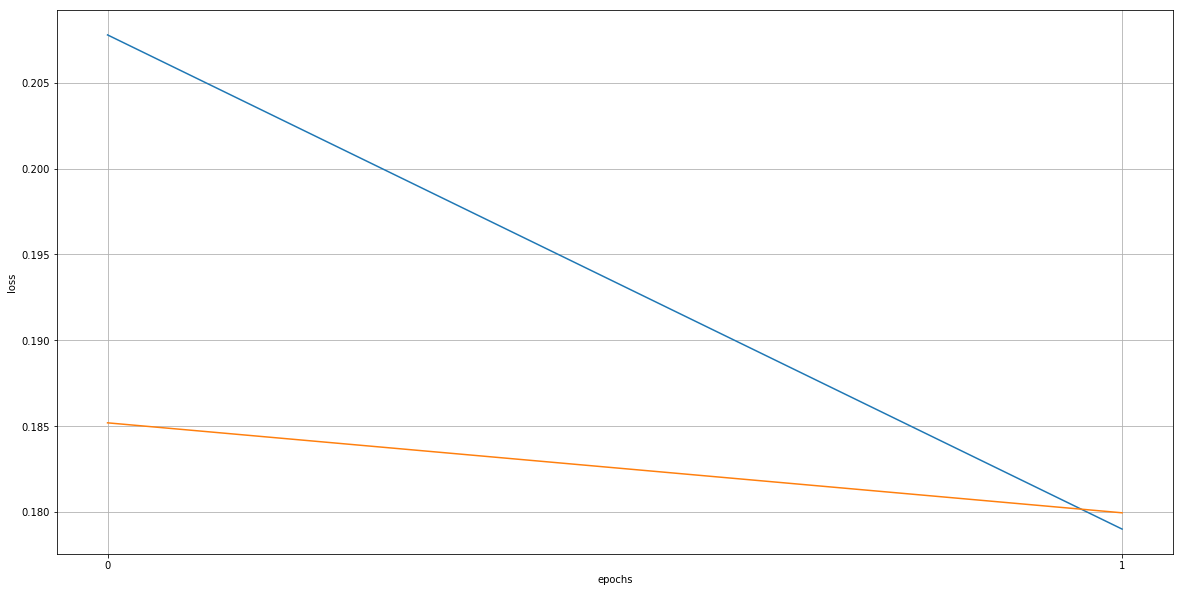

In [10]:
# visualize the loss as the network trained
fig = plt.figure(figsize=(20,10))
plt.plot(range(0,epochs),avg_train_losses, label='Training Loss')
plt.plot(range(0,epochs),avg_valid_losses, label='Validation Loss')

plt.xlabel('epochs')
plt.xticks(range(0,epochs))
plt.ylabel('loss')
plt.grid()
plt.show

In [11]:
x_test , y_test = next(iter(train_dataset))
#sentimentrnn.cpu()
#sentimentrnn.to(device)
sentimentrnn.eval()
y_pred = sentimentrnn(x_test.to(device))
y_pred
print(y_pred.argmax(dim = 1),'\n')

y_test = y_test.to(device)
print(y_test,'\n')

print(y_pred.argmax(dim = 1).eq(y_test),'\n')
print(y_pred.argmax(dim = 1).eq(y_test).sum())

tensor([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1,
        1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0,
        0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1,
        1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1,
        1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1,
        1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1,
        0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1,
        0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1,
        0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1,
        0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1,
        1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1,
        0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1,
        1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0,

In [12]:
x_test , y_test = next(iter(test_dataset))
#sentimentrnn.cpu()
#sentimentrnn.to(device)
sentimentrnn.eval()
y_pred = sentimentrnn(x_test.to(device))
y_pred
print(y_pred.argmax(dim = 1),'\n')

y_test = y_test.to(device)
print(y_test,'\n')

print(y_pred.argmax(dim = 1).eq(y_test),'\n')
print(y_pred.argmax(dim = 1).eq(y_test).sum())

tensor([0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1,
        0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
        1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1,
        1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1,
        0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0,
        1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1,
        1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0,
        0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1,
        0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
        0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1,
        1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0,
        1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0,

In [128]:
#creating training data
#def create_input_data(sentence):
#    sentence = sentence.lower().replace('[^\w\s]','').replace('.',' ').split()
#    input_data = np.zeros((seq_len,batch_size,embedding_dim))
#    k = 0
#    #print(corpus)
#    for i in sentence:
#        if i == '<>':
#            word_vector = np.zeros(embedding_dim)
#        else:
#            word_vector = word2vec.wv[i] 
#        input_data[k][0] = word_vector
#        k+=1
#        #print(i)
#    return torch.tensor(input_data , dtype = torch.float64)

#input_data = create_input_data('I love that they put their food in nice plastic containers as opposed to cramming it in little paper takeout boxes.')

In [101]:
#batch = 0
#for i in train_dataset :
#    x, y = next(iter(train_dataset))
#    print(batch)
#    batch+=1
#    print(x.shape,y.shape)

In [102]:
#hidden = torch.zeros((num_layers,batch_size , hidden_size),dtype = torch.float64)
#c_0 = torch.zeros((num_layers,batch_size, hidden_size),dtype = torch.float64)
#sample_lstm1 = nn.LSTM(input_size = 128, hidden_size = 128 , num_layers = 5 , batch_first = True)
#sample_lstm1.double()

#print('hidden.shape :{}'.format(hidden.shape))
#print('c_0.shape : {}'.format(c_0.shape))
#print('x.shape : {}'.format(x.shape))
#lstm_out , hidden_out = sample_lstm1(x , (hidden.cuda(),c_0.cuda()))
#print('lstm_out.shape :{}'.format(lstm_out.shape))
#print('hidden_out.shape :{}'.format(hidden_out.shape))
#print(hidden_out[1].shape)


In [104]:
#x, y = next(iter(train_dataset))
#y_pred = sentimentrnn(x.to(device))
#print(y_pred.shape)
#print(y.shape)
#loss = F.cross_entropy(y_pred ,y.to(device()))
#print(loss)